# Choose filters parameters

    creation date:     09/10/2024, 07h26

    modification date: 09/10/2024, 22h33

    author: Millot Laurent



## What this notebook does:

- installation of pre-defined mapping(s) (Audio, Leipp, Octaves or Sono)
- configuration of the tools (creation of all needed folders and relative
  subfolders, of the mapping's files and of sets of the subbands filters)

In [1]:
import numpy as np
import pathlib

import Sub_ToBo.tools_files_folders.tools_files_folders as fldrTls
import Sub_ToBo.tools_ids_configuration.tools_mapping_creation as mpgTls
import Sub_ToBo.tools_ids.tools_ids_filters as fltrTls
import Sub_ToBo.tools_plot.tools_frequency_plots as pltTls
import Sub_ToBo.tools_wav.tools_wav_read as wvrdTls



main_path = pathlib.Path.cwd()
tools_data_path = main_path / "data_subbands_tools"
mappings_def_path = tools_data_path / "mappings_definitions"
subbands_filters_path = tools_data_path / "subbands_filters"

fig_path = main_path / "filters_figures"
fldrTls.create_new_subfolder(fig_path)




# ---------
def delete_filters_set(mapping_name, sample_rate, ripple_dB, width_Hz):
    
    ir_length, _ = fltrTls.determine_Kaiser_parameters(ripple_dB, width_Hz, 
                                                       sample_rate // 2)

    filters_subfolder_name = "h_" + mapping_name + "_"\
        + str(int(sample_rate/100)) + "_" + str(int(ir_length))

    the_path = subbands_filters_path / filters_subfolder_name
    fldrTls.delete_folder(the_path)


# ----------
def process_configuration(sample_rate, mapping_name, mapping_key, 
                          subbands_number, subbands_frequencies_limits_array, 
                          ripple_dB=80.0, width_Hz=5.0):
    
    # régler le problème de suppression du dossier contenant le jeu de filtres !
    # h_Illustration_441_4427

    filters_sets_folders_names_list, _ = \
        fldrTls.list_subfolders(subbands_filters_path)
        
    ir_length_array, subfolders_list  = \
        fldrTls.get_possible_filters_sets(filters_sets_folders_names_list, mapping_name, 
                                          sample_rate)

    for subfolder in subfolders_list:
        the_path = subbands_filters_path / subfolder
        fldrTls.delete_folder(the_path)
        
    mpgTls.remove_one_mapping(mapping_name, sample_rate, ripple_dB, width_Hz)
    # delete_filters_set(mapping_name, sample_rate,ripple_dB, width_Hz)

    new_mapping = mpgTls.Mapping(sample_rate, mapping_name, mapping_key, 
                                 subbands_number,  
                                 subbands_frequencies_limits_array)


    mpgTls.create_new_mapping(new_mapping.mapping_name, new_mapping, 
                          sample_rate, ripple_dB, width_Hz)

    mpgTls.list_installed_mappings()
    
    return new_mapping

 
# ----------
def get_filters_set_infos(subbands_filters_path):
    
    filters_sets_folders_names_list, _ = \
        fldrTls.list_subfolders(subbands_filters_path)
        
    ir_length_array, subfolders_list  = \
        fldrTls.get_possible_filters_sets(filters_sets_folders_names_list, 
                                          new_mapping.mapping_name, 
                                          sample_rate)
    
    ir_length_array = ir_length_array[0]
    subfolder_name = subfolders_list[0]
    
    print()
    print(f"ir_length_array: {ir_length_array}")
    print(f"subfolder_name: {subfolder_name}")
    print()
    
    return ir_length_array, subfolder_name
 
    
def get_filter_IR(new_mapping, subband_index, filter_subfolder_name):
    
    subbands_frequencies_array = new_mapping.subbands_frequencies_array
    
    left_freq = subbands_frequencies_array[subband_index - 1]
    right_freq = subbands_frequencies_array[subband_index]
    
    filter_name = str(left_freq) + "_" + str(right_freq) + ".wav"
    
    file_path = subbands_filters_path / filter_subfolder_name / filter_name
    header = wvrdTls.read_wav_header(file_path)
    
    ir_array = wvrdTls.read_wav_file(file_path, header)
    ir_array = ir_array.T
    
    freq_limits_list = [left_freq, right_freq]
    
    return ir_array, filter_name, freq_limits_list
    

# ----------
def process_filter_study(new_mapping, subband_index, sample_rate, ripple_dB, 
                         width_Hz):

    ir_length_array, filter_subfolder_name = \
        get_filters_set_infos(subbands_filters_path)
    
    ir_array, filter_name, freq_limits_list = \
        get_filter_IR(new_mapping, subband_index, filter_subfolder_name)
    
    print()
    print(f"filter_name: {filter_name}")
    print()
    
    freq_limits_list = [int(.9 * freq_limits_list[0]), int(1.1 * freq_limits_list[1])]
    
    filter_name = filter_name[:-4] + "_" + str(int(ripple_dB))+ "dB_w"\
        + str(int(width_Hz)) + "Hz.wav"
    
    pltTls.plot_dB_spectrum(ir_array, sample_rate, filter_name, fig_path,
                                freq_limits_list)


# ----------
def process_filters_study(new_mapping, sample_rate, ripple_dB, width_Hz):

    ir_length_array, filter_subfolder_name = \
        get_filters_set_infos(subbands_filters_path)
    
    IRs_number = new_mapping.subbands_number
    
    IRs_array = np.zeros((IRs_number, ir_length_array))
    
    for k in range(IRs_number):
        ir_array, _, freq_limits_list = \
            get_filter_IR(new_mapping, k + 1, filter_subfolder_name)
        
        IRs_array[k, :] = ir_array
    
    title_name = new_mapping.mapping_name + str(int(ripple_dB)) + "_dB_w" \
        + str(int(width_Hz)) + "Hz.wav"
    
    pltTls.plot_logx_dB_spectra(IRs_array, IRs_number, sample_rate, 
                                title_name, fig_path, 
                                [1, sample_rate // 2])            

In [5]:
# ----- mapping's parameters
# minimum attenuation in stop-band (in dB)
ripple_dB = 80.0

# width of the transition subband (in Hz)
width_Hz = 5.0

# sample rate (in Hz)
sample_rate = 44100

# mapping name
mapping_name = "Illustration"

# capital letter to identify the mapping
mapping_key = "I"

# subbands frequencies without Nyquist frequency (sample_rate // 2) 
# which would be added automatically during the installation process
subbands_frequencies_limits_array = [0, 250, 500, 3000, 10000]

# number fo the subbands constituting the frequency mapping
subbands_number = len(subbands_frequencies_limits_array)

# launch the installation process and the creation of the user-defined 
# frequency mapping
new_mapping = \
    process_configuration(sample_rate, mapping_name, mapping_key, 
                          subbands_number, subbands_frequencies_limits_array, 
                          ripple_dB, width_Hz)



Installed frequency mappings:

Audio (A) / 13 / [0, 30, 60, 80, 100, 120, 250, 500, 1000, 2000, 4000, 8000, 16000, 22050]

Illustration (I) / 5 / [0, 250, 500, 3000, 10000, 22050]

Leipp (L) / 10 / [0, 50, 200, 400, 800, 1200, 1800, 3000, 6000, 15000, 22050]





ir_length_array: 44263
subfolder_name: h_Illustration_441_44263


filter_name: 0_250.wav



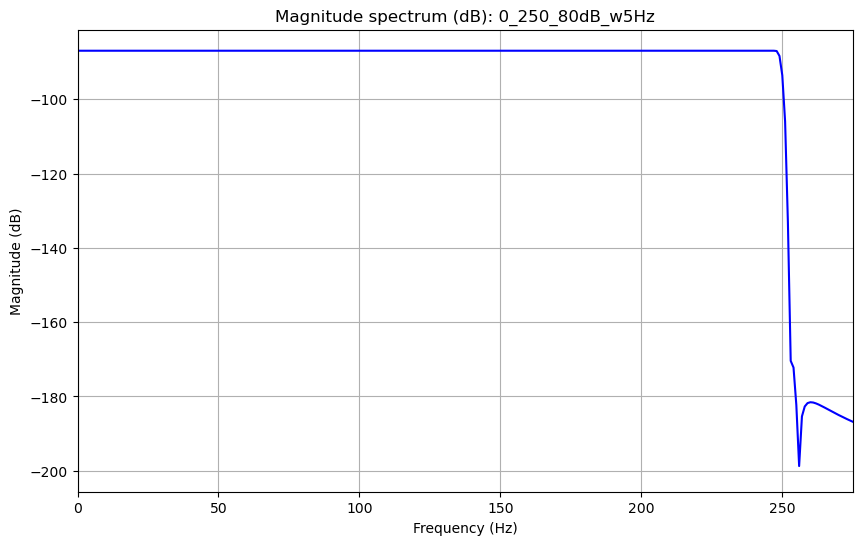

In [8]:
# plot the dB gain for one of the subbands filters
subband_index = 1
process_filter_study(new_mapping, subband_index, sample_rate, ripple_dB, width_Hz)



ir_length_array: 44263
subfolder_name: h_Illustration_441_44263



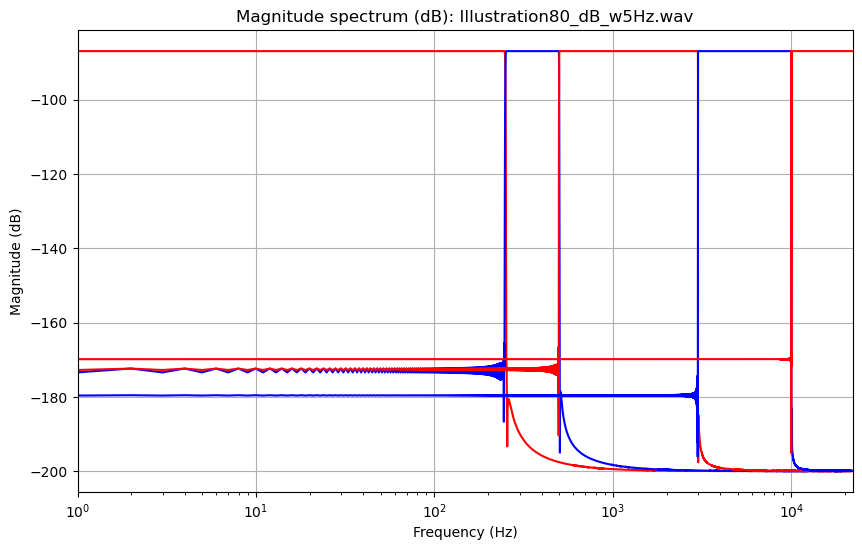

In [9]:
# plot the dB gains for all the subbands filters on the same plot
process_filters_study(new_mapping, sample_rate, ripple_dB, width_Hz)